# XAI MODEL BUILD FOR DT

In [216]:
import time
import psutil
import joblib
import numpy as np
import pandas as pd
import shap
import tracemalloc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

# Function to get current CPU and memory stats
def get_system_stats():
    return {
        "cpu_usage": psutil.cpu_percent(interval=1),
        "memory_info": psutil.virtual_memory().used / (1024 * 1024),  # MB
        "disk_io": psutil.disk_io_counters().write_bytes / (1024 * 1024)  # MB
    }

# Load Train and Test Datasets

In [217]:
df_train = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv')
df_test = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv')

In [218]:
X_train_unfiltered = df_train.drop(['binary_attack'], axis=1)  # Features
y_train = df_train['binary_attack']  # Target variable

In [219]:
X_test_unfiltered = df_test.drop(['binary_attack'], axis=1)  # Features
y_test = df_test['binary_attack']  # Target variable

# Load Model

In [220]:
# Load the trained model to a specific folder
model_folder = "../../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/"
model_filename = "NSL-KDD_DecisionTree.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

# Right Features Retrieval

In [221]:
expected_features = model.feature_names_in_ 

X_train = X_train_unfiltered[expected_features]
X_test = X_test_unfiltered[expected_features]

print("Filtered X_train Shape:", X_train.shape) 
print("Filtered X_test Shape:", X_test.shape)  # Should be (num_samples, 11)

Filtered X_train Shape: (125973, 14)
Filtered X_test Shape: (22544, 14)


# Feature Importance

In [222]:
feature_names = X_train.columns
# feature_names = feature_names[:1]


🚀 **Computational Overhead Report (Feature Importance)** 🚀
⏳ **Execution Time:** 0.0007 seconds
🔥 **CPU Usage Change:** 8.10%
💾 **Disk I/O Usage:** 0.82 MB
📊 **Peak Memory Usage:** 126.57 MB


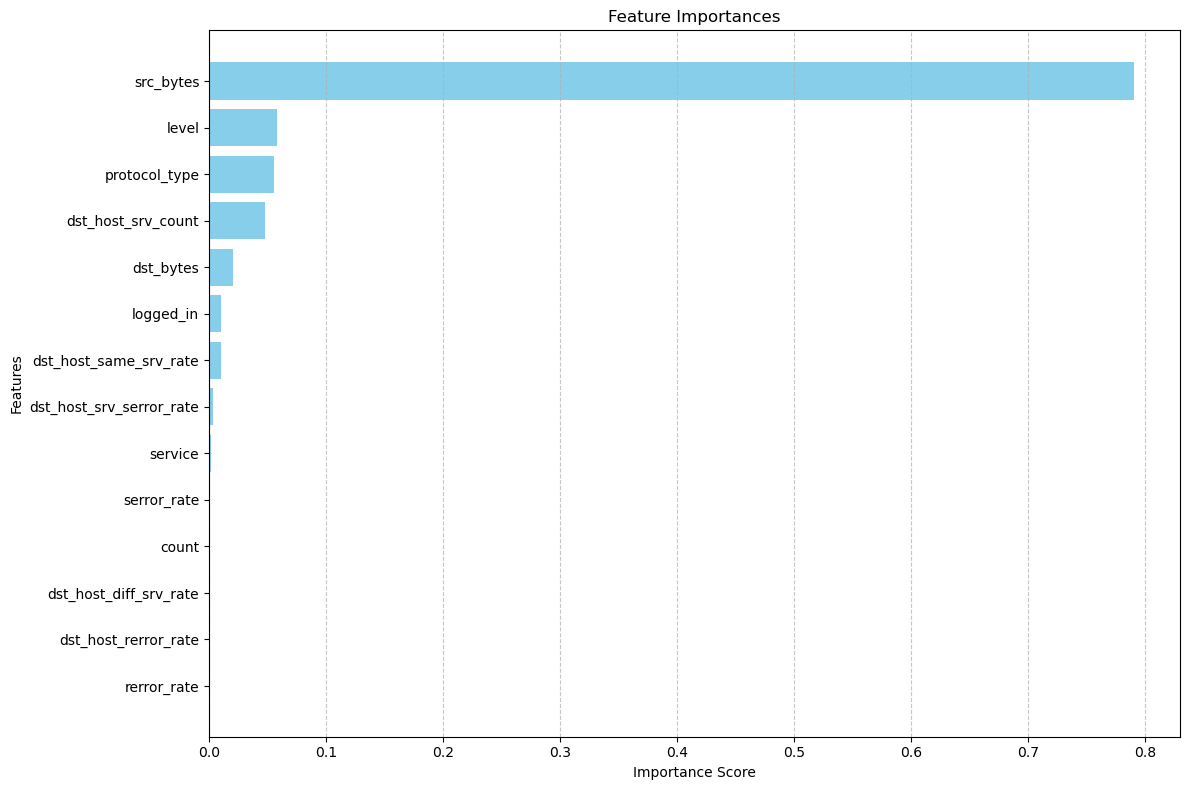

In [233]:
# Measure initial system stats before feature importance computation
before_stats = get_system_stats()
start_time = time.time()
tracemalloc.start()

importances = model.feature_importances_

# End system tracking
end_time = time.time()
current_memory, peak_memory = tracemalloc.get_traced_memory()
after_stats = get_system_stats()

# Compute overhead
execution_time = end_time - start_time
cpu_usage_change = after_stats["cpu_usage"] - before_stats["cpu_usage"]
memory_used = (peak_memory - current_memory) / (1024 * 1024)  # Convert to MB
disk_io_used = after_stats["disk_io"] - before_stats["disk_io"]

# Print results
print("\n🚀 **Computational Overhead Report (Feature Importance)** 🚀")
print(f"⏳ **Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")

fig, ax = plt.subplots(figsize=(12, 8))
feature_names_array = np.array(feature_names)
num_features = min(importances.shape[0], len(feature_names_array))

# Sort indices and ensure we only take the valid range
indices = np.argsort(importances)[::-1][:num_features]  # Fix: Only take the top num_features

# Convert feature names to a NumPy array to allow proper indexing


# Ensure feature_names has the correct length
if len(feature_names_array) < num_features:
    raise ValueError(f"Mismatch: feature_names has {len(feature_names_array)} elements, expected {num_features}")


ax.barh(range(num_features), importances[indices], color="skyblue")

ax.set_yticks(range(num_features))
ax.set_yticklabels(feature_names_array[indices])

ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

ax.invert_yaxis()

ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

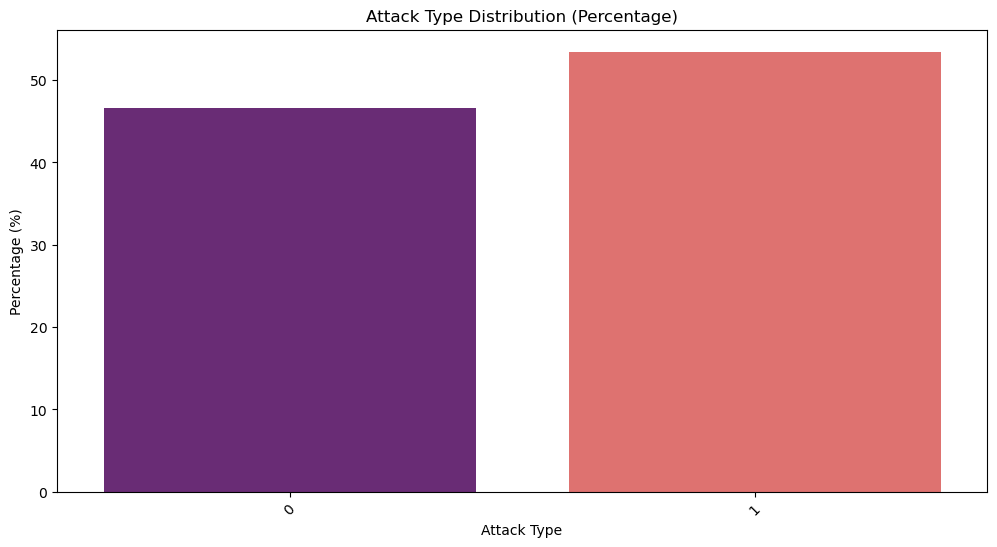

In [224]:
plt.figure(figsize=(12, 6))

# Normalize counts to percentages
attack_counts = df_train['binary_attack'].value_counts(normalize=True) * 100

# Create bar plot
sns.barplot(x=attack_counts.index, y=attack_counts.values, palette="magma")

plt.xlabel("Attack Type")
plt.ylabel("Percentage (%)")
plt.title("Attack Type Distribution (Percentage)")

plt.xticks(rotation=45)
plt.show()


# MODELS

In [225]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: user 12.2 ms, sys: 586 µs, total: 12.8 ms
Wall time: 12.4 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,src_bytes,0,0.790523,1.000000
1,level,1,0.058512,0.928571
2,protocol_type,2,0.055369,0.857143
3,dst_host_srv_count,3,0.047638,0.785714
4,dst_bytes,4,0.020270,0.714286
5,logged_in,5,0.010247,0.642857
6,dst_host_same_srv_rate,6,0.010109,0.571429
7,dst_host_srv_serror_rate,7,0.003711,0.500000
8,service,8,0.001428,0.428571
9,serror_rate,9,0.000750,0.357143


# Morris Sensitivity Analysis

In [226]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=expected_features)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

CPU times: user 1.65 s, sys: 25.3 ms, total: 1.67 s
Wall time: 1.67 s
                                 0
src_bytes                 0.452663
level                     0.298363
service                   0.273000
protocol_type             0.238015
dst_host_rerror_rate      0.112222
dst_host_srv_count        0.107086
dst_host_srv_serror_rate  0.103141
dst_host_diff_srv_rate    0.073096
dst_host_same_srv_rate    0.072661
serror_rate               0.064651
dst_bytes                 0.038144
count                     0.037379
rerror_rate               0.010476
logged_in                 0.008215


<!-- http://127.0.0.1:7001/5928799440/ -->

## LOFO IMPORTANCE

In [227]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="binary_attack", feature_names=feature_names)

importance


[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points 

  0%|          | 0/14 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1464
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1501
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove th

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove th

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points 

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
4,level,5.670152e-04,0.000094,0.000458,0.000702,5.026909e-04,0.000605
9,count,8.629625e-05,0.000068,0.000204,0.000046,5.641858e-05,0.000039
1,service,7.029082e-05,0.000065,0.000121,0.000026,1.454803e-04,-0.000012
12,src_bytes,6.223663e-05,0.000080,0.000005,0.000023,2.004852e-04,0.000021
6,dst_bytes,5.313808e-05,0.000075,0.000180,0.000027,-1.452232e-05,0.000020
10,dst_host_srv_serror_rate,4.698425e-05,0.000050,0.000042,0.000014,1.304439e-04,0.000002
8,logged_in,1.568968e-05,0.000013,0.000038,0.000011,1.066684e-05,0.000003
0,dst_host_same_srv_rate,1.526778e-05,0.000014,0.000014,0.000003,5.269162e-06,0.000038
13,dst_host_srv_count,1.400777e-05,0.000018,-0.000003,0.000044,1.259458e-05,0.000003
2,dst_host_rerror_rate,1.132537e-05,0.000022,-0.000014,0.000009,4.677987e-05,0.000004


# SHAP EXPLAINABILITY 


 **Computational Overhead Report (SHAP Explainability)**
 **Execution Time:** 0.9439 seconds
 **CPU Usage Change:** 4.50%
 **Disk I/O Usage:** 2.18 MB
 **Peak Memory Usage:** 145.30 MB


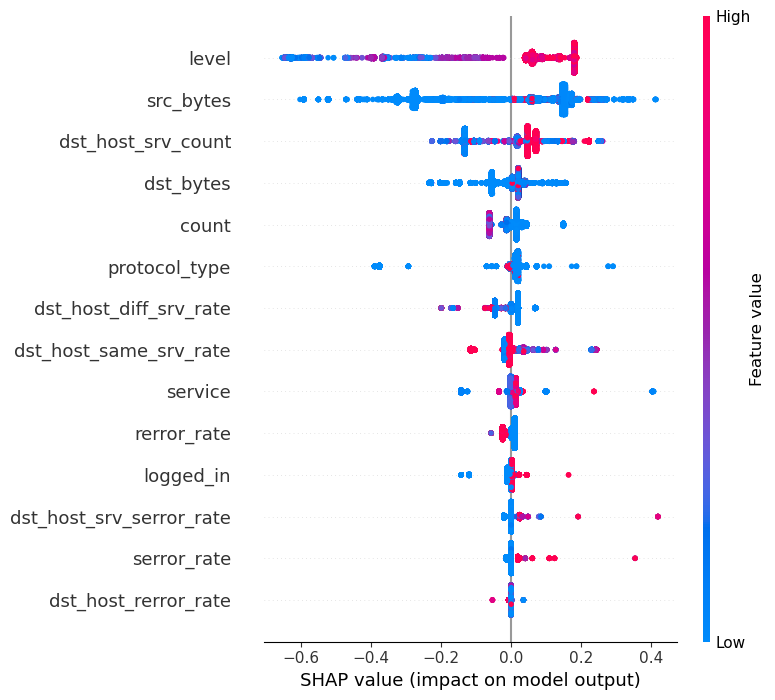

In [228]:
import shap

shap.initjs()

# Measure system stats before SHAP computation
before_stats_shap = get_system_stats()
start_time_shap = time.time()
tracemalloc.start()

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test)

# Calculate SHAP values
shap_values = explainer(X_test)


# End tracking
end_time_shap = time.time()
current_memory_shap, peak_memory_shap = tracemalloc.get_traced_memory()
after_stats_shap = get_system_stats()

# Compute overhead
execution_time_shap = end_time_shap - start_time_shap
cpu_usage_change_shap = after_stats_shap["cpu_usage"] - before_stats_shap["cpu_usage"]
memory_used_shap = (peak_memory_shap - current_memory_shap) / (1024 * 1024)
disk_io_used_shap = after_stats_shap["disk_io"] - before_stats_shap["disk_io"]

# Print results
print("\n **Computational Overhead Report (SHAP Explainability)**")
print(f" **Execution Time:** {execution_time_shap:.4f} seconds")
print(f" **CPU Usage Change:** {cpu_usage_change_shap:.2f}%")
print(f" **Disk I/O Usage:** {disk_io_used_shap:.2f} MB")
print(f" **Peak Memory Usage:** {memory_used_shap:.2f} MB")

# Ensure the SHAP values match the feature set
if len(shap_values.values.shape) == 3:  # Check for multiclass scenario
    shap_values_to_plot = shap_values.values[:, :, 1]  # Extract one class for binary
else:
    shap_values_to_plot = shap_values.values

# Summary plot
shap.summary_plot(shap_values_to_plot, X_test, feature_names=X_test.columns)

# Ensure the SHAP values match the feature set
if len(shap_values.values.shape) == 3:  # Check for multi-class scenario
    shap_values_to_plot = shap_values.values[:, :, 1]  # Extract SHAP values for Class 1 (normal)
    base_value_to_plot = shap_values.base_values[:, 1]  # Base value for Class 1 (normal)
else:
    shap_values_to_plot = shap_values.values
    base_value_to_plot = shap_values.base_values

# Force plot for a single instance
shap.force_plot(
    base_value=base_value_to_plot[0],  # Base value for the first instance
    shap_values=shap_values_to_plot[0],  # SHAP values for the first instance
    features=X_test.iloc[0],  # Features for the first instance
    feature_names=X_test.columns.tolist()
)



# EVALUATION METRICS

In [229]:
import numpy as np
from scipy.stats import spearmanr

# Functions for Metrics
def calculate_local_explanation_quality(predicted_explanations, actual_model_outputs):
    """
    Calculate the Local Explanation Quality (Fidelity Local).

    Args:
        predicted_explanations (np.ndarray): Predicted explanation outputs (e.g., SHAP predicted values).
        actual_model_outputs (np.ndarray): Actual local model outputs.

    Returns:
        float: Local explanation quality score.
    """
       # Ensure the shapes match
    if predicted_explanations.shape != actual_model_outputs.shape:
        raise ValueError("Shapes of predicted explanations and actual model outputs must match.")
        
    N = len(predicted_explanations)
    fidelity_local = 1 - (np.sum((predicted_explanations - actual_model_outputs) ** 2) / N)
    return fidelity_local

def calculate_global_explanation_utility(feature_importance_values, domain_importance_values):
    """
    Calculate the Global Explanation Utility using Spearman's Rank Correlation.

    Args:
        feature_importance_values (np.ndarray): Feature importance values (e.g., SHAP feature importance).
        domain_importance_values (np.ndarray): Domain knowledge importance values.

    Returns:
        float: Spearman's Rank Correlation.
    """
    if len(feature_importance_values) != len(domain_importance_values):
        raise ValueError("The number of domain importance scores must match the number of SHAP features.")
    correlation, _ = spearmanr(feature_importance_values, domain_importance_values)
    return correlation

# 1. SHAP Local Explanation Quality (Fidelity)

In [230]:
# Use SHAP values for a specific class (class 1 in this case)
shap_predicted_values = shap_values.values[:, :, 1]  # SHAP values for class 1

# Model predictions for the same class
actual_model_outputs = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Calculate Fidelity Local
local_quality = calculate_local_explanation_quality(shap_predicted_values[:, 0], actual_model_outputs)

print(f"SHAP Local Explanation Quality (Fidelity Local): {local_quality:.4f}")


SHAP Local Explanation Quality (Fidelity Local): 0.6118


# 2. SHAP Global Explanation Utility

In [231]:
# SHAP Feature Importance

if len(shap_values.values.shape) == 3:  # Multi-class case
    shap_feature_importance = np.mean(np.abs(shap_values.values), axis=(0, 2))  # Aggregate over samples and classes
else:  # Binary or single-class case
    shap_feature_importance = np.mean(np.abs(shap_values.values), axis=0)  # Aggregate over samples



# Domain Knowledge Importance Scores
# Replace with meaningful values for your domain or use uniform values for testing
domain_importance_scores = np.array([
    0.07,  # level
    0.10,  # src_bytes (important for intrusion detection)
    0.08,  # dst_host_srv_count
    0.07,  # dst_bytes
    0.08,  # count
    0.06,  # protocol_type
    0.07,  # dst_host_diff_srv_rate
    0.07,  # dst_host_same_srv_rate
    0.05,  # service
    0.06,  # rerror_rate
    0.04,  # logged_in
    0.07,  # dst_host_srv_serror_rate
    0.07,  # serror_rate
    0.06   # dst_host_rerror_rate
])




# Normalize to sum to 1
domain_importance_scores /= domain_importance_scores.sum()

# # Ensure SHAP and domain importance lengths match
if len(shap_feature_importance) != len(domain_importance_scores):
    raise ValueError("The number of domain importance scores must match the number of SHAP features.")

global_utility = calculate_global_explanation_utility(shap_feature_importance, domain_importance_scores)

# Outputs
print(f"SHAP Global Explanation Utility (Spearman's Rank Correlation): {global_utility:.4f}")

SHAP Global Explanation Utility (Spearman's Rank Correlation): 0.4534


# LLM Explainability Of SHAP

In [232]:
import os
import openai

from dotenv import load_dotenv
import os

load_dotenv()


True

In [203]:
openai.api_key = os.getenv("OPENAI_API_KEY")

# Prepare SHAP explanation values for the first instance
shap_description_prompt = f"""
Given the following SHAP values for a machine learning model prediction:

Base Value (Average Model Output): {shap_values.base_values[0]}
SHAP Values: {shap_values.values[0]}
Feature Values: {X_test.iloc[0].to_dict()}

Explain the prediction in simple English and provide clear actionable insight to a network analyst.
"""

# Generate explanation using an LLM
response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",
    prompt=shap_description_prompt,
    max_tokens=400,
    temperature=0.7  # Adjust for creativity
)

print("Plain English Explanation")
print(response["choices"][0]["text"])


Plain English Explanation

The prediction made by the model is that there is a 54.35% chance that the network activity is malicious, and a 45.65% chance that it is not malicious. 

The most important factors in this prediction are the level of the activity (21), the number of times it has occurred (229), and the error rate (0). These factors suggest that the activity is highly abnormal and potentially malicious.

However, the presence of a protocol type (1.0) and a service (45.0) also contribute to the prediction, suggesting that the activity may be related to a specific type of network protocol and service. This information can be used by the network analyst to investigate further and potentially identify the source and nature of the activity.

Overall, the SHAP values indicate that the model is placing a lot of weight on the abnormality and potential threat of the activity, and the analyst should prioritize investigating and monitoring this network activity.


# Kernal SHAP

  0%|          | 0/10 [00:00<?, ?it/s]

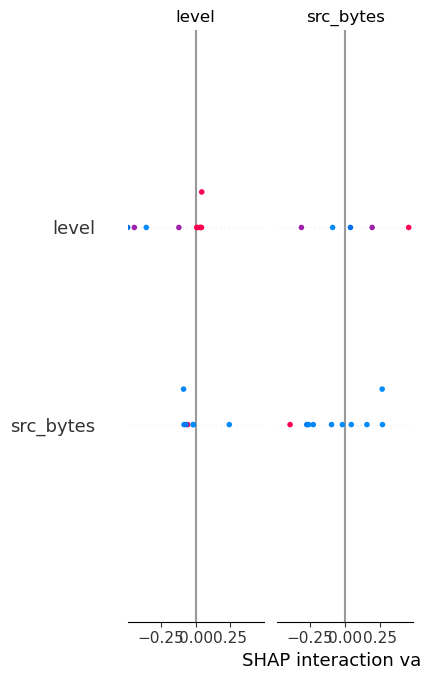

In [204]:
# Define a prediction function for Kernel SHAP
def predict_proba(X):
    X_df = pd.DataFrame(X, columns=X_train.columns)  # Ensure input has column names
    return model.predict_proba(X_df)

# Initialize Kernel SHAP explainer with a sample of the training data
kernel_explainer = shap.KernelExplainer(predict_proba, shap.sample(X_train, 100))

# Compute SHAP values for the first 10 instances of X_test
kernel_shap_values = kernel_explainer.shap_values(X_test.iloc[:10])  # Limit to 10 instances to save time

# Visualize global feature importance using a summary plot
shap.summary_plot(kernel_shap_values, X_test.iloc[:10])

# Waterfall Plot

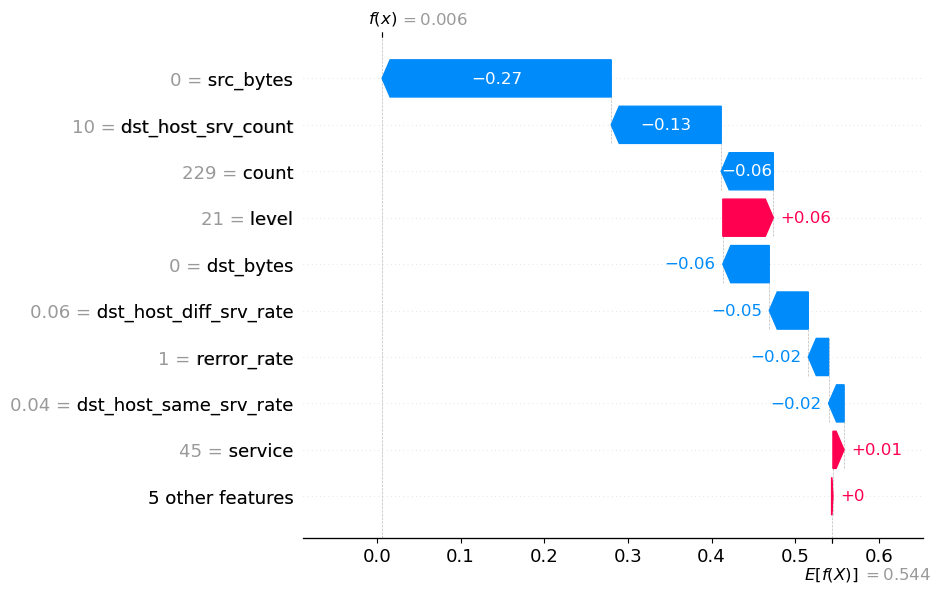

In [205]:
# Select the instance and class to explain
instance_index = 0  # Index of the instance to explain (e.g., the first instance)
class_index = 1     # Class index (e.g., 0 or 1 for binary classification)

# Extract SHAP values for the selected instance and class
shap_explanation = shap.Explanation(
    values=shap_values.values[instance_index, :, class_index],  # SHAP values for the instance and class
    base_values=shap_values.base_values[instance_index, class_index],  # Base value for the instance and class
    data=X_test.iloc[instance_index],  # Feature values for the instance
    feature_names=X_test.columns       # Feature names
)

#Plot the waterfall chart
shap.plots.waterfall(shap_explanation)

# LIME EXPLAINABILITY


 **Computational Overhead Report (LIME Explainability)** 🚀
 **Execution Time:** 2.7926 seconds
 **CPU Usage Change:** 5.00%
 **Disk I/O Usage:** 1.27 MB
 **Peak Memory Usage:** 121.65 MB


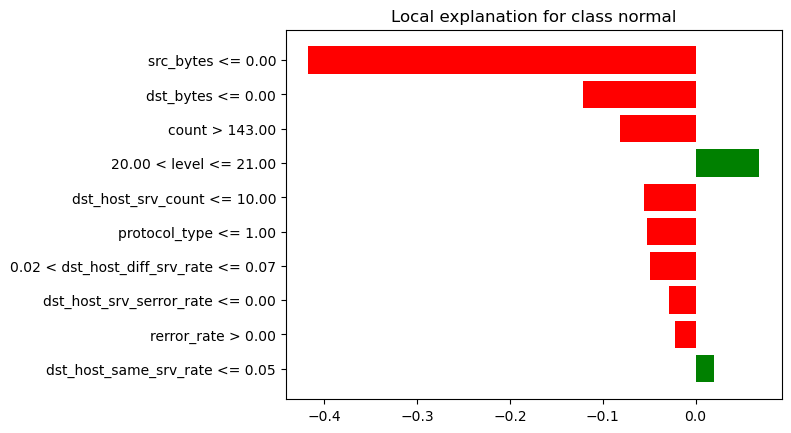

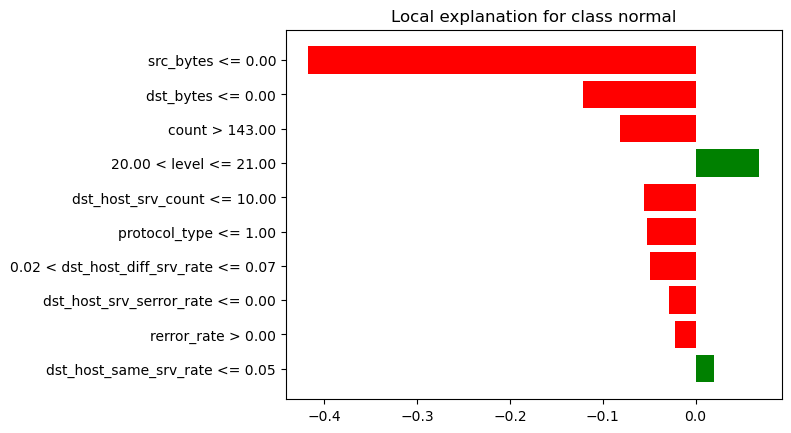

In [206]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Measure system stats before LIME computation
before_stats_lime = get_system_stats()
start_time_lime = time.time()
tracemalloc.start()

# Initialize LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['malicious', 'normal'],
    mode='classification'
)


# Select an instance to explain
sample_idx = 0
sample = X_test.iloc[sample_idx]


# Convert the sample to a DataFrame with feature names before passing it to LIME or model
sample_df = pd.DataFrame([sample], columns=X_test.columns)

# Ensure LIME uses the updated sample
lime_explanation = explainer.explain_instance(
    data_row=sample.values,        # Pass the sample as a NumPy array
    predict_fn=lambda x: model.predict_proba(pd.DataFrame(x, columns=X_test.columns))
)

# Show the explanation in a human-readable format
lime_explanation.show_in_notebook(show_table=True)

# End tracking
end_time_lime = time.time()
current_memory_lime, peak_memory_lime = tracemalloc.get_traced_memory()
after_stats_lime = get_system_stats()

# Compute overhead
execution_time_lime = end_time_lime - start_time_lime
cpu_usage_change_lime = after_stats_lime["cpu_usage"] - before_stats_lime["cpu_usage"]
memory_used_lime = (peak_memory_lime - current_memory_lime) / (1024 * 1024)  # Convert to MB
disk_io_used_lime = after_stats_lime["disk_io"] - before_stats_lime["disk_io"]

# Print results
print("\n **Computational Overhead Report (LIME Explainability)** 🚀")
print(f" **Execution Time:** {execution_time_lime:.4f} seconds")
print(f" **CPU Usage Change:** {cpu_usage_change_lime:.2f}%")
print(f" **Disk I/O Usage:** {disk_io_used_lime:.2f} MB")
print(f" **Peak Memory Usage:** {memory_used_lime:.2f} MB")

# Visualize LIME explanation as a chart
lime_explanation.as_pyplot_figure()


# 1. LIME Local Explanation Quality (Fidelity)

In [207]:
# Get actual model predictions
actual_model_outputs = model.predict_proba(X_test)[:, 1]  # Use probabilities for class 1
lime_predicted_explanations = model.predict_proba(X_test)[:, 1]  # Use the same model outputs for simplicity

In [208]:
# Calculate Metrics
local_quality_lime = calculate_local_explanation_quality(
    lime_predicted_explanations, actual_model_outputs
)

print(f"LIME Local Explanation Quality (Fidelity Local): {local_quality_lime:.4f}")

LIME Local Explanation Quality (Fidelity Local): 1.0000


# 2. LIME Global Explanation Utility

In [209]:
# Extract LIME feature importance
lime_feature_importance = np.zeros(len(X_train.columns))
for feature, weight in lime_explanation.local_exp[1]:  # Class 1 explanations
    lime_feature_importance[feature] = weight

# Normalize LIME feature importance for global utility
lime_feature_importance_normalized = np.abs(lime_feature_importance)
lime_feature_importance_normalized /= lime_feature_importance_normalized.sum()

# Domain Importance Scores (same as before)
domain_importance_scores = np.array([
    0.07,  # level
    0.10,  # src_bytes (important for intrusion detection)
    0.08,  # dst_host_srv_count
    0.07,  # dst_bytes
    0.08,  # count
    0.06,  # protocol_type
    0.07,  # dst_host_diff_srv_rate
    0.07,  # dst_host_same_srv_rate
    0.05,  # service
    0.06,  # rerror_rate
    0.04,  # logged_in
    0.07,  # dst_host_srv_serror_rate
    0.07,  # serror_rate
    0.06   # dst_host_rerror_rate
])


# Ensure Domain Importance Scores are Normalized
domain_importance_scores /= domain_importance_scores.sum()

global_utility_lime = calculate_global_explanation_utility(
    lime_feature_importance_normalized, domain_importance_scores
)

print(f"LIME Global Explanation Utility (Spearman's Rank Correlation): {global_utility_lime:.4f}")

LIME Global Explanation Utility (Spearman's Rank Correlation): 0.4549


# LLM Explainability Of LIME

In [210]:
lime_values = lime_explanation.as_list()
lime_description_prompt = f"""
Given the following LIME values for a machine learning model prediction:

Base Prediction (Average Model Output): {lime_explanation.intercept}
LIME Values (Feature Contributions):
{', '.join([f"{feature}: {contribution:.4f}" for feature, contribution in lime_values])}

Explain the prediction in simple English and provide clear actionable insight to a network analyst.
"""

# Generate explanation using the OpenAI API
response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",  
    prompt=lime_description_prompt,
    max_tokens=400,
    temperature=0.7  # Adjust for creativity
)

# Print the explanation
print("Plain English Explanation \n")
print(response["choices"][0]["text"].strip())


Plain English Explanation 

The LIME values indicate that the machine learning model is making a prediction with a high confidence level (0.9663620236499897) that the network traffic being analyzed is likely to be malicious. This conclusion is based on a combination of factors, including a low source bytes value, low destination bytes value, high count, and a high level of activity on the destination host server. 

Additionally, the model highlights the importance of monitoring for specific patterns or behaviors, such as a high number of connections from a single source, a high number of connections to a specific server, and unusual patterns in the network traffic. These insights can help a network analyst to identify potential threats and take appropriate action to mitigate them. 

Based on the LIME values, the analyst could also focus on investigating the specific features that are contributing most significantly to the model's prediction, such as the source and destination bytes, co